In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [2]:
data = pd.read_csv(r"D:\Python\PSD\SentimenHotel\tripadvisor_hotel_reviews.csv")
df = pd.DataFrame(data)
df.head()

,review,rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [3]:
# Clean text function
def clean_text(text):
    return re.sub('[^a-zA-Z]', ' ', text).lower()
    
df['cleaned_text'] = df['review'].apply(clean_text)
df['label'] = df['rating'].map({1.0:0, 2.0:0, 3.0:1, 4.0:1, 5.0:1})

In [4]:
# Count punctuation percentage
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

df['review_len'] = df['review'].apply(lambda x: len(x) - x.count(" "))
df['punct'] = df['review'].apply(count_punct)
df.head()

,review,rating,cleaned_text,label,review_len,punct
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,1,505,2.4
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,0,1438,1.8
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms not experience hotel monaco seat...,1,1209,2.6
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monac...,1,510,3.1
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game aweso...,1,1089,3.7


In [5]:
# Tokenize text
def tokenize_text(text):
    tokenized_text = text.split()
    return tokenized_text

df['cleaned_text'] = df['cleaned_text'].apply(tokenize_text)
df.head()

,review,rating,cleaned_text,label,review_len,punct
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d...",1,505,2.4
1,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member...",0,1438,1.8
2,nice rooms not 4* experience hotel monaco seat...,3,"[nice, rooms, not, experience, hotel, monaco, ...",1,1209,2.6
3,"unique, great stay, wonderful time hotel monac...",5,"[unique, great, stay, wonderful, time, hotel, ...",1,510,3.1
4,"great stay great stay, went seahawk game aweso...",5,"[great, stay, great, stay, went, seahawk, game...",1,1089,3.7


In [6]:
# Lemmatize text
def lemmatize_text(token_list):
    lemmatizer = WordNetLemmatizer()
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    return " ".join([lemmatizer.lemmatize(token) for token in token_list if not token in set(all_stopwords)])

df['lemmatized_review'] = df['cleaned_text'].apply(lemmatize_text)
df.head()

,review,rating,cleaned_text,label,review_len,punct,lemmatized_review
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d...",1,505,2.4,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member...",0,1438,1.8,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,"[nice, rooms, not, experience, hotel, monaco, ...",1,1209,2.6,nice room not experience hotel monaco seattle ...
3,"unique, great stay, wonderful time hotel monac...",5,"[unique, great, stay, wonderful, time, hotel, ...",1,510,3.1,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,"[great, stay, great, stay, went, seahawk, game...",1,1089,3.7,great stay great stay went seahawk game awesom...


In [7]:
# Apply preprocessing
#df['cleaned_text'] = df['review'].apply(clean_text)
#df['review_len'] = df['review'].apply(lambda x: len(x) - x.count(" "))
#df['punct'] = df['review'].apply(count_punct)
#df['cleaned_text'] = df['cleaned_text'].apply(tokenize_text)
#df['lemmatized_review'] = df['cleaned_text'].apply(lemmatize_text)
#df['label'] = df['rating'].map({1.0:0, 2.0:0, 3.0:1, 4.0:1, 5.0:1})

In [8]:
df.to_csv('Dataset.csv', index = False)

In [9]:
import plotly.express as px

 # Menghitung jumlah data per rating
rating_counts = df['rating'].value_counts().reset_index()
rating_counts.columns = ['rating', 'count']

 # Plot bar chart interaktif menggunakan Plotly Express
fig = px.bar(rating_counts, x='rating', y='count', title='Distribution of Ratings',
             labels={'rating': 'Rating', 'count': 'Count'}, color='rating',
              color_discrete_map={1.0: 'red', 2.0: 'orange', 3.0: 'purple', 4.0: 'green', 5.0: 'blue'})
fig.update_layout(xaxis_title='Rating', yaxis_title='Count')
fig.show()

# Jumlah null values di kolom rating dan review
null_rating = df['rating'].isnull().sum()
null_review = df['review'].isnull().sum()
print(f"Number of null in label: {null_rating}")
print(f"Number of null in text: {null_review}")


Number of null in label: 0
Number of null in text: 0


In [10]:
df_negative = df[ (df['rating']==1.0) | (df['rating']==2.0)]
df_positive = df[ (df['rating']==3.0) | (df['rating']==4.0) | (df['rating']==5.0)]

#convert to list
negative_list=df_negative['lemmatized_review'].tolist()
positive_list= df_positive['lemmatized_review'].tolist()

filtered_negative = ("").join(str(negative_list)) #convert the list into a string of spam
filtered_negative = filtered_negative.lower()

filtered_positive = ("").join(str(positive_list)) #convert the list into a string of ham
filtered_positive = filtered_positive.lower()

In [11]:
# create positive words file
with open('positive_words.txt', 'w') as f:
    for word in filtered_positive:
        f.write(f'{word}')

# create negative words file
with open('negative_words.txt', 'w') as f:
    for word in filtered_negative:
        f.write(f'{word}')

In [12]:
# # create positive words dataframe
# positive_df = pd.DataFrame({'words': filtered_positive})

# # create negative words dataframe
# negative_df = pd.DataFrame({'words': filtered_negative})

# # save dataframes to csv files
# positive_df.to_csv('positive_words.csv', index=False)
# negative_df.to_csv('negative_words.csv', index=False)

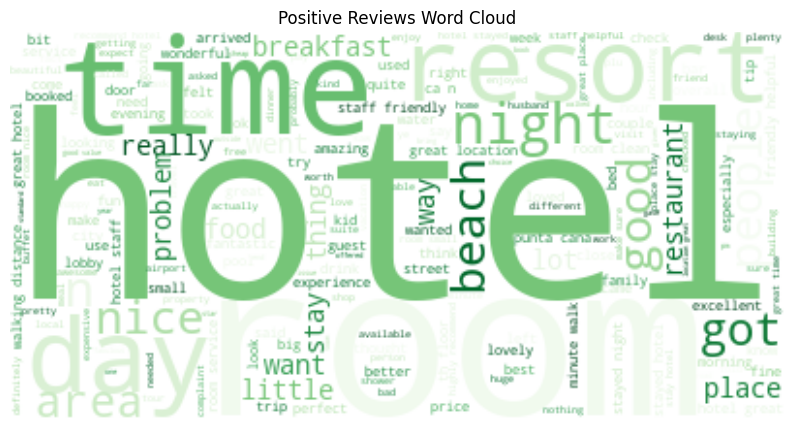

In [13]:
wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="Greens").generate(filtered_positive)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Positive Reviews Word Cloud")
plt.show()

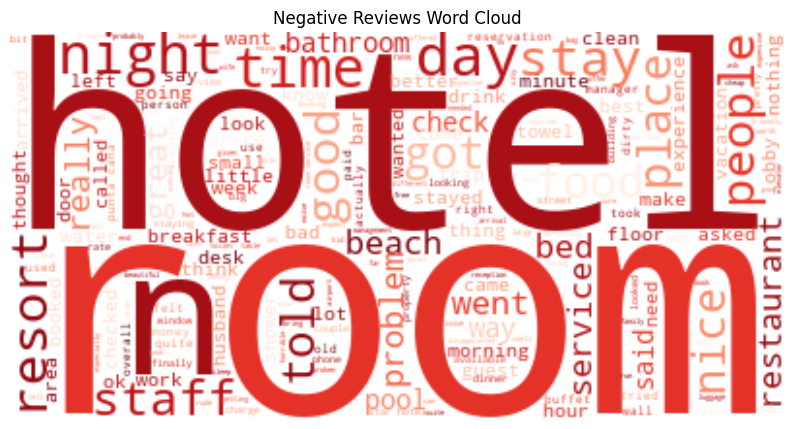

In [14]:
wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="Reds").generate(filtered_negative)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Negative Reviews Word Cloud")
plt.show()

In [15]:
# Split data into features and target
X = df[['lemmatized_review', 'review_len', 'punct']]
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
# Vectorization using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['lemmatized_review'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['lemmatized_review'])

In [17]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=1000, random_state=0)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())

In [18]:
# Combine text features with numerical features
X_train_numerical = X_train[['review_len', 'punct']].reset_index(drop=True)
X_train_vect = pd.concat([X_train_numerical, pd.DataFrame(X_train_pca)], axis=1)

X_test_numerical = X_test[['review_len', 'punct']].reset_index(drop=True)
X_test_vect = pd.concat([X_test_numerical, pd.DataFrame(X_test_pca)], axis=1)

In [19]:
# Fill NaN values (if any)
X_train_vect = X_train_vect.fillna(0)
X_test_vect = X_test_vect.fillna(0)

# Convert feature names to string
X_train_vect.columns = X_train_vect.columns.astype(str)
X_test_vect.columns = X_test_vect.columns.astype(str)

In [20]:
# Visualisasi rating sebelum SMOTE
rating_counts_before_smote = y_train.value_counts().reset_index()
rating_counts_before_smote.columns = ['label', 'count']

fig = px.bar(rating_counts_before_smote, x='label', y='count', title='Distribution of Ratings before SMOTE',
             labels={'label': 'Rating', 'count': 'Count'}, color='label',
             color_discrete_map={0: 'orange', 1: 'green'})
fig.update_layout(xaxis_title='Rating', yaxis_title='Count')
fig.show()

In [21]:
# Apply SMOTE for oversampling
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vect, y_train)

In [22]:
y_train_resampled.to_csv('rating_distribution_after_smote.csv', index=False)


In [23]:
smot = pd.read_csv('rating_distribution_after_smote.csv')

smot.head(10)

# smot.info()

,label
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [24]:
def hitung_label(data):
    # asumsikan 'data' adalah DataFrame pandas
    # dan 'label' adalah nama kolom yang berisi data 1 dan 0
    jumlah_label_1 = sum(data['label'] == 1)
    jumlah_label_0 = sum(data['label'] == 0)
    
    print(f"Jumlah label 1: {jumlah_label_1}")
    print(f"Jumlah label 0: {jumlah_label_0}")

hitung_label(smot)


Jumlah label 1: 13818
Jumlah label 0: 13818


In [25]:
# Visualisasi rating setelah SMOTE
rating_counts_resampled = pd.Series(y_train_resampled).value_counts().reset_index()
rating_counts_resampled.columns = ['label', 'count']

fig = px.bar(rating_counts_resampled, x='label', y='count', title='Distribution of Ratings after SMOTE',
             labels={'label': 'Rating', 'count': 'Count'}, color='label',
             color_discrete_map={0: 'orange', 1: 'green'})
fig.update_layout(xaxis_title='Rating', yaxis_title='Count')
fig.show()

In [26]:
# Train RandomForest model

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

et_model = ExtraTreesClassifier(n_estimators=100, random_state=0)
et_model.fit(X_train_resampled, y_train_resampled)

ExtraTreesClassifier(random_state=0)

In [27]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Predict with Extra Trees
y_pred_et = et_model.predict(X_test_vect)

# Calculate accuracy
acc_et = accuracy_score(y_test, y_pred_et)
print("Accuracy of Extra Trees: {:.2f}%".format(acc_et * 100))

# Calculate F1 score
f1_et = f1_score(y_test, y_pred_et, average='weighted')
print("F1 Score of Extra Trees: {:.2f}".format(f1_et))

# Calculate precision
precision_et = precision_score(y_test, y_pred_et, average='weighted')
print("Precision of Extra Trees: {:.2f}".format(precision_et))

# Calculate recall
recall_et = recall_score(y_test, y_pred_et, average='weighted')
print("Recall of Extra Trees: {:.2f}".format(recall_et))



Accuracy of Extra Trees: 88.83%
F1 Score of Extra Trees: 0.87
Precision of Extra Trees: 0.88
Recall of Extra Trees: 0.89


In [30]:
from sklearn.metrics import confusion_matrix, classification_report

In [31]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression model
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_resampled, y_train_resampled)

C:\Users\Argy\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(random_state=0)

In [32]:
# Predict with Logistic Regression
y_pred_lr = lr_model.predict(X_test_vect)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy of Logistic Regression: {:.2f}".format(acc_lr*100))

print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Accuracy of Logistic Regression: 90.29
[[ 573   67]
 [ 331 3128]]
              precision    recall  f1-score   support

           0       0.63      0.90      0.74       640
           1       0.98      0.90      0.94      3459

    accuracy                           0.90      4099
   macro avg       0.81      0.90      0.84      4099
weighted avg       0.93      0.90      0.91      4099



In [33]:
import xgboost as xgb

# Train XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=0)
xgb_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [34]:
# Predict with XGBoost
y_pred_xgb = xgb_model.predict(X_test_vect)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("Accuracy of XGBoost: {:.2f}".format(acc_xgb*100))


print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

Accuracy of XGBoost: 91.27
[[ 514  126]
 [ 232 3227]]
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       640
           1       0.96      0.93      0.95      3459

    accuracy                           0.91      4099
   macro avg       0.83      0.87      0.84      4099
weighted avg       0.92      0.91      0.92      4099

